# Problem Statement

### Part 1 : Data Analysis

The attached CSV 'purchase2019.csv'file lists the customer, date, and dollar value of orders placed at a store in 2017. The actual gender and predicted gender of each customer is also provided. For each part, please state the insights or assumptions you think are valuable. 


In [549]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

A) Assemble a dataframe with one row per customer and the following columns:
    * customer_id
    * gender
    * most_recent_order_date
    * order_count (number of orders placed by this customer)
   Sort the dataframe by customer_id ascending and display the first 10 rows.

In [550]:
# read in purchase2019 data
# sort cust_id by ascending and date by descending (to ensure latest date remains when removing duplicates cust id items with earlier dates)
purchase = pd.read_csv("purchase2019.csv")
purchase.sort_values(by=['customer_id','date'], ascending=[True, False], inplace = True)

In [551]:
# count number of orders by cust_id
# rename series column to 'order_counts'
order_count = purchase['customer_id'].value_counts().rename('order_count')

In [552]:
# join order_counts with purchase records on customer_id
# and remove duplicated customer_id items
purchase_counts = pd.merge(purchase, order_count, how='inner', left_on='customer_id', right_index=True)
purchase_counts.drop_duplicates('customer_id', inplace=True)
purchase_counts.drop(['value','predicted_gender'], axis=1, inplace=True)
purchase_counts.rename(columns={'date':'most_recent_order_date'}, inplace=True)

In [553]:
# dropping columns to show only requested columns
# showing the top 10 records
purchase_counts.head(10)

,customer_id,gender,most_recent_order_date,order_count
0,1000,0,2017-01-01 00:11:31,1
1,1001,0,2017-01-01 00:29:56,1
1742,1002,1,2017-02-19 21:35:31,3
4323,1003,1,2017-04-26 02:37:20,4
4,1004,0,2017-01-01 03:11:54,1
12953,1005,1,2017-12-16 01:39:27,2
4798,1006,1,2017-05-09 15:27:20,3
7,1007,0,2017-01-01 15:59:50,1
12991,1008,0,2017-12-17 05:47:48,3
9,1009,1,2017-01-01 19:27:17,1


B) Plot the count of orders per week for the store.

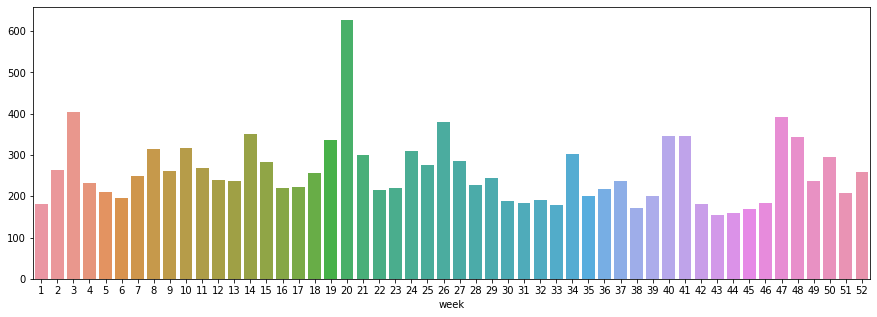

In [554]:
from matplotlib import pyplot as plt
import seaborn as sn

# starting with original data => purchase
# convert date to week of the year
purchase['week'] = pd.to_datetime(purchase['date']).dt.week

# count weekly orders
weekly_order_counts = purchase.groupby('week')['customer_id'].count().rename('weekly_order_counts')

plt.figure(figsize=(15,5))
sn.barplot(weekly_order_counts.index, weekly_order_counts.values)

C) Compute the mean order value for gender 0 and for gender 1. Do you think the difference is significant?

In [555]:
purchase.groupby('gender')['value'].mean()

gender
0    363.890006
1    350.708361
Name: value, dtype: float64

_Observation:_
* No I don't think the difference is significant

D) Assuming a single gender prediction was made for each customer, generate a confusion matrix for predicted gender. What does the confusion matrix tell you about the quality of the predictions?

In [556]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

cm = confusion_matrix(purchase['gender'], purchase['predicted_gender'], normalize='true')
# Due to the size of the data, I believe it makes better sense to normalize the numbers, 
# so the decimal points can be interpreted as percentages
cm

array([[0.4954875 , 0.5045125 ],
       [0.21796782, 0.78203218]])

Text(33.0, 0.5, 'True Gender')

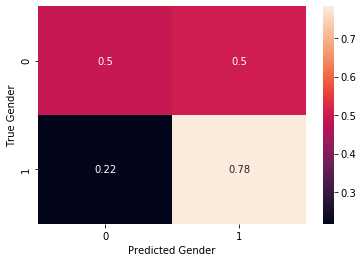

In [557]:
fig = sn.heatmap(cm, annot=True)
plt.xlabel("Predicted Gender")
plt.ylabel("True Gender")

_Observation:_
* According to the confusion matrix above, the true prediction on gender 0 is 50% whereas the true prediction on gender 1 is 78%.  

E) Describe one of your favorite tools or techniques and give a small example of how it's helped you solve a problem. Limit your answer to one paragraph.

One of my favorite ML tools has to be the sklearn package.  The package is a one stop shop for almost all my ML needs.  The package includes tools for data preprocessing, partitioning, cleaning, modeling, and all the way to model evaluation.  For instance, if I were to work on a new set of data, I could use sklearn's train_test_split to partition my dataset into training and testing/validation sets without having to explicitly write a script for the partitioning process.  Once the datasets are split, I could then directly feed the training set into a sklean's modeling function of my choice.  After the model has been successfully trained, I could use one of sklearn's evaluation methods from sklean's metrics package to test accuracy or quality of my prediction model.  And in the case of the above example, if I wanted, I could have even used sklearn's plot_confusion_matrix to plot/visualize the quality of the prediction.  

### Part 2 : Prediction

### Find a model that can predict the median price of apartments based on other features in the 'apt_pricing.csv' data set. 

In [558]:
import pandas as pd
import numpy as np
import sklearn 
import matplotlib
import seaborn as sn
%matplotlib inline

Loading the data set

In [559]:
df = pd.read_csv('apt_pricing.csv')

In [560]:
df.head(5)

,longitude,latitude,apt_median_age,total_rooms,total_bedrooms,population,households,median_income,median_apt_value,location
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# EDA / Data Processing

In [561]:
# Plot the data in the way you like for different columns. 
# What are your observations ? 
# Are there any intersting insights that you can use from the plots to improve your model later ?

_Observation:_
* According to plots below, the predictors total_rooms, total_bedrooms, population, households appear to be highly correlated to each other; this is an indication of collinearity among the predictors, which is not a good thing, and we could potentially mitigate this issue by either direclty eliminating some of these predcitors or use a dimensionality reduction method such as PCA to tranform the predictor space and use the transformed predictor space to feed into the model.


* None of the continuous predictors seem to be truly normally distribution, most seem to be in a chi-square distribution while apt_median_age and median_apt_value do not seem to belong to any formally defined distribution

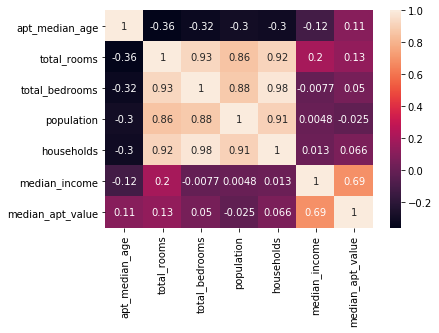

In [562]:
corr_table = df.iloc[:,2:].corr()

fig = sn.heatmap(corr_table, annot=True)

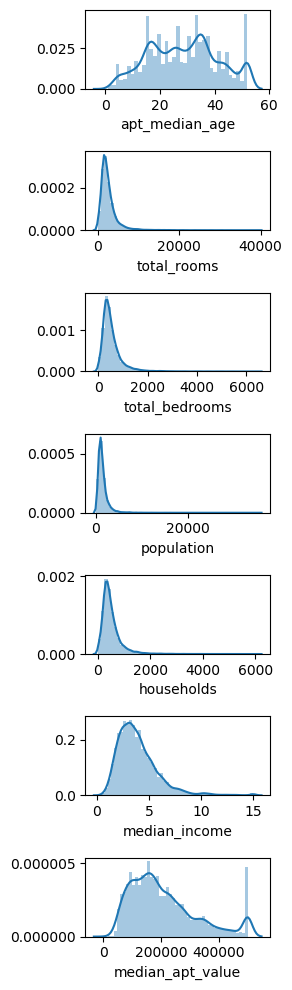

In [563]:
fig, axes = plt.subplots(7, 1, figsize=(3, 10), sharey=False, dpi=100)

i = 0
for col in df.columns[2:9]:
    sns.distplot(df[col], ax=axes[i], axlabel=col)
    i += 1
    
fig.tight_layout()

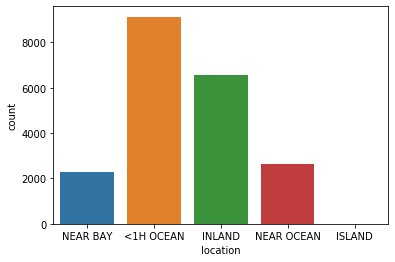

In [564]:
sn.countplot(x = df['location'])

In [565]:
# Apply a transformation to the numerical columns so they all have mean of 0 and variance of 1.

In [566]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

mtrx_norm = scaler.fit_transform(df.iloc[:,:9])

In [567]:
# The 'location' column is text. Modify it so you can use it as a numerical feature. 
# Your new dataframe should consist of all the previous numerical columns as well as the new modified features for the "ocean_proximity" column.

In [568]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

#encoder.fit([df.location.unique()])
X_loc = encoder.fit_transform(np.array(df.location).reshape(-1,1)).toarray()

In [569]:
colnames = df.columns[:9].tolist() + encoder.categories_[0].tolist()

df_norm = pd.DataFrame(np.hstack((mtrx_norm, X_loc)), columns=colnames)

In [570]:
df_norm.head(3)

,longitude,latitude,apt_median_age,total_rooms,total_bedrooms,population,households,median_income,median_apt_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0.211155,0.567481,0.784314,0.022331,0.019863,0.008941,0.020556,0.539668,0.902266,0.0,0.0,0.0,1.0,0.0
1,0.212151,0.565356,0.392157,0.180503,0.171477,0.067210,0.186976,0.538027,0.708247,0.0,0.0,0.0,1.0,0.0
2,0.210159,0.564293,1.000000,0.037260,0.029330,0.013818,0.028943,0.466028,0.695051,0.0,0.0,0.0,1.0,0.0


In [571]:
# Identify which column has missing values. What is your strategy for dealing with those values ?

In [572]:
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   longitude         20640 non-null  float64
 1   latitude          20640 non-null  float64
 2   apt_median_age    20640 non-null  float64
 3   total_rooms       20640 non-null  float64
 4   total_bedrooms    20433 non-null  float64
 5   population        20640 non-null  float64
 6   households        20640 non-null  float64
 7   median_income     20640 non-null  float64
 8   median_apt_value  20640 non-null  float64
 9   <1H OCEAN         20640 non-null  float64
 10  INLAND            20640 non-null  float64
 11  ISLAND            20640 non-null  float64
 12  NEAR BAY          20640 non-null  float64
 13  NEAR OCEAN        20640 non-null  float64
dtypes: float64(14)
memory usage: 2.2 MB


In [573]:
# below shows the number of missing values by column
df_norm.isnull().sum()

longitude             0
latitude              0
apt_median_age        0
total_rooms           0
total_bedrooms      207
population            0
households            0
median_income         0
median_apt_value      0
<1H OCEAN             0
INLAND                0
ISLAND                0
NEAR BAY              0
NEAR OCEAN            0
dtype: int64

In [574]:
# given the number of missing value is fairly negligible compared to the overall sample size
# I've decided to drop the missing value
# however, if the number of missing values is large compared to the sample size, then
# I would've chosen to either upsample the total_bedrooms or fill in missing with mean of the variable
df_norm.dropna(inplace=True)

In [575]:
# confirm no Nan or missing values
df_norm.isnull().sum()

longitude           0
latitude            0
apt_median_age      0
total_rooms         0
total_bedrooms      0
population          0
households          0
median_income       0
median_apt_value    0
<1H OCEAN           0
INLAND              0
ISLAND              0
NEAR BAY            0
NEAR OCEAN          0
dtype: int64

# Training  / Model Evaluation

In [576]:
# Choose a tree-based regressor with default parameters to perform training on the data. 
# Use 10-fold Cross Validation. 
# Set the total number of trees to be 10.
# Choose the proper metric to evaluate the accuracy of your model. 

###### Preprocessing data

In [577]:
from sklearn.model_selection import train_test_split

X = df_norm.drop('median_apt_value', axis=1).to_numpy()
y = df_norm['median_apt_value'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state = 0)

###### Fitting the model

In [578]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=10)

# fitting the model
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

###### Evaluating Perormance

* I have selected mean squared error and R^2 as evaluation metrics for this model since it is a regression model

In [579]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, r2_score

# mean square error and R^2 are couple of the most common measures for regression
# so we'll cv to get readings on both of these
metrics = ['neg_mean_squared_error', 'r2']
rfr_cv_scores = cross_validate(rfr, X, y, cv=10, scoring=metrics)

In [580]:
# the small mse of the model indicates a good performance
rfr_cv_scores['test_neg_mean_squared_error'].mean()

-0.022741919884758866

In [581]:
# since higher R^2 score usually indicate better performance
# 0.50 indicates that the above model has room for improvement
rfr_cv_scores['test_r2'].mean()

0.49722799626609315

##### Feature Importance

In [582]:
# Use the tree-based regressor to determine the most important features that impact the prediction accuracy.

In [583]:
# extracting feature names
features = df_norm.columns.tolist()
features.remove('median_apt_value')

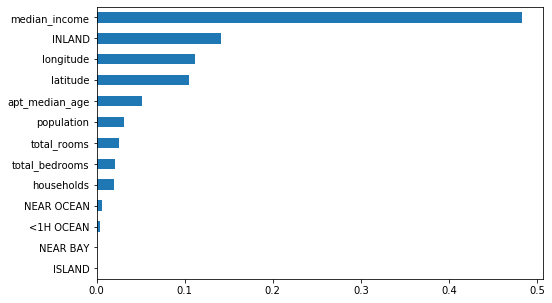

In [584]:
# The table below shows each feature's important with relevance to predicting the target
feature_ranking = pd.Series(data=rfr.feature_importances_,index=features).sort_values()

matplotlib.rcParams['figure.figsize'] = (8, 5.0)
feature_ranking.plot(kind='barh')

_Observation:_
* According to table above, the top 5 most relevant features that impact the prediction are: _median_income, INLAND, longitude, latitude, apt_median_age_

###### Alternative Feature Selection
* L1 Based - LassoCV

In [585]:
# Use a different machine learning approach to find the most important features in the dataset.
# Compare the results with your findings from the tree-based regressor model.

In [586]:
from sklearn.linear_model import LassoCV
# LassoCV
lasso = LassoCV(cv=10)
lasso.fit(X,y)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

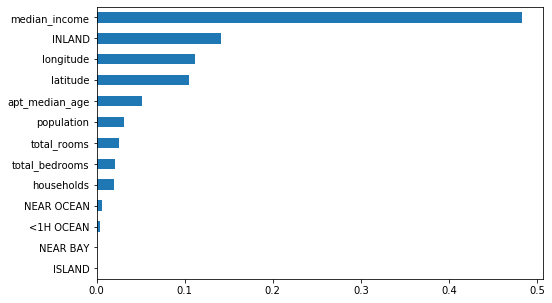

In [587]:
feature_ranking_lasso = pd.Series(data=lasso.coef_, index=features).sort_values()

matplotlib.rcParams['figure.figsize'] = (8, 5.0)
feature_ranking.plot(kind='barh')

_Observation:_
* The feature importance indicated by the linear model's lassoCV concurs with that of the tree-based approach

###### Hyperparameter Tuning - GridSearchCV

In [588]:
# Fix the total number max depth of the tree (N) to be 10  and let the max depth of the tree (d) to vary from 2 to 10 in steps of 2 .
# Find out the choice of 'd' that result in the best prediciton accuracy.  (Assume 5 fold cross validation)

In [589]:
from sklearn.model_selection import GridSearchCV

grid = {'max_depth': np.arange(2,11,2)}

rfr = RandomForestRegressor(max_depth=10)
rfr_grid = GridSearchCV(estimator=rfr,
                        param_grid=grid,
                        cv=5)

rfr_grid.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=10,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [590]:
rfr_grid.best_params_

{'max_depth': 4}

_Observation_
* According to the output above, the optimal value for max_depth that results in the best prediction accuracy is __4__